## Cart Pole RL
Policy erlenen, indem 100 Epochen durchgeführt und die besten 30 gefiltert und zum Erkennen von Mustern genutzt werden. Werden der 100 Epochen, wird die Policy nicht angepasst.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List, Tuple


from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
class Agent:
    def __init__(self, env: gym.Env) -> None:
        self.env = env
        self.observations: int = self.env.observation_space.shape[0] # Anzahl Observation States
        self.actions: int = self.env.action_space.n # Anzahl Actions (Hier 2)
        self.model = self.get_model()

    def get_model(self) -> Sequential:
        model = Sequential()
        model.add(Dense(units=100, input_dim=self.observations))
        model.add(Activation("relu"))
        model.add(Dense(units=self.actions))
        model.add(Activation("softmax"))
        model.summary()
        model.compile(
            optimizer=Adam(learning_rate=0.007),
            loss="categorical_crossentropy",
        )
        return model

    def get_action(self, state: Any) -> Any:
        state = state.reshape(1, -1)
        policy = self.model(state, training=False).numpy()[0] 
            # [0.7, 0.3] Wahrschlichkeit für jede Aktion in den Step. In Summe immer =1
            # Aktion Links tritt mit 70%iger Wahrscheinlichkeit ein
            # Kann hier als Policy angesehen werden
        return np.random.choice(self.actions, p=policy)

    def get_samples(self, num_episodes: int) -> Tuple[List[float], List[Any]]: 
        rewards = [0.0 for _ in range(num_episodes)]
        episodes: List[Any] = [[] for _ in range(num_episodes)]

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0.0

            while True:
                action = self.get_action(state)
                new_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                episodes[episode].append((state, action))
                state = new_state
                if done:
                    rewards[episode] = total_reward
                    break
        return rewards, episodes

    def filter_episodes(
        self,
        rewards: List[float],
        episodes: List[Tuple[Any, Any]],
        percentile: float,
    ) -> Tuple[np.ndarray, np.ndarray, float]:
        reward_bound = np.percentile(rewards, percentile)
        x_train = []
        y_train = []
        for reward, epsiode in zip(rewards, episodes):
            if reward >= reward_bound:
                observation = [step[0] for step in epsiode]
                action = [step[1] for step in epsiode]
                x_train.extend(observation)
                y_train.extend(action)
        x_train = np.asarray(x_train)
        y_train = to_categorical(y_train, num_classes=self.actions)
        return x_train, y_train, reward_bound


    def train(
        self, percentile: float, num_iterations: int, num_episodes: int
    ) -> Tuple[List[float], List[float]]:
        reward_means: List[float] = []
        reward_bounds: List[float] = []
        for it in range(num_iterations):
            rewards, episodes = self.get_samples(num_episodes)
            x_train, y_train, reward_bound = self.filter_episodes(
                rewards, episodes, percentile
            )
            self.model.train_on_batch(x=x_train, y=y_train)
            reward_mean = np.mean(rewards)
            print(
                f"Iteration: {it:2d} "
                f"Reward Mean: {reward_mean:.4f} "
                f"Reward Bound: {reward_bound:.4f}"
            )
            reward_bounds.append(reward_bound)
            reward_means.append(reward_mean)
        return reward_means, reward_bounds


    def play(self, episodes: int, render: bool = True) -> None:
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0.0

            while True:
                if render:
                    self.env.render()
                action = self.get_action(state)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break

            print(f"Episode: {episode} Total Reward: {total_reward}")
        self.env.close()

In [3]:
def main() -> None:
    env = gym.make("CartPole-v1")
    agent = Agent(env)
    reward_means, reward_bounds = agent.train(percentile=70.0, num_iterations=30, num_episodes=100)
    input()
        # 30 Episoden mit je 100 Iterationen, die 70% der guten filtern
    agent.play(episodes=10)

    plt.title("Training Performance")
    plt.plot(range(len(reward_means)), reward_means, color="red")
    plt.plot(range(len(reward_bounds)), reward_bounds, color="blue")
    plt.legend(["reward_means", "reward_bounds"])
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________
Iteration:  0 Reward Mean: 18.8800 Reward Bound: 20.3000
Iteration:  1 Reward Mean: 23.8100 Reward Bound: 25.0000
Iteration:  2 Reward Mean: 26.3000 Reward Bound: 29.3000
Iteration:  3 Rewar

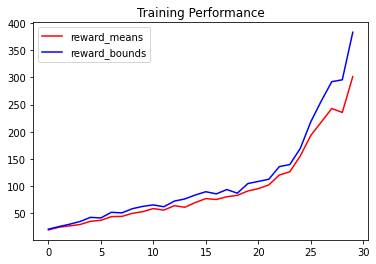

In [4]:
if __name__ == "__main__":
    main()